In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
from configs import task_dataframe

In [3]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
df = pd.read_pickle(f'{root_dir}/results/results.pkl')

In [5]:
df

,_runtime,obj,_step,_wandb,detail,overall,textual,visual,_timestamp,valid_count,...,model,stage,task_id,x_space,file_type,task_type,misleading,theta_space,run_name,run_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,emu,eval,7,action,text,action_animal,0,animal,sweet-serenity-537,jdhpwrg2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,gpt4v,eval,1,color,text,color_object,0,object,wobbly-brook-536,7haroq61
2,468.200782,198.0,0.0,{'runtime': 466},698.0,151.0,198.0,698.0,1.704793e+09,1000.0,...,emu,eval,6,object,text,style_object,0,style,apricot-river-535,vz99prne
3,265.786002,988.0,0.0,{'runtime': 264},206.0,205.0,206.0,988.0,1.704792e+09,1000.0,...,emu,eval,5,style,text,style_object,0,object,resilient-star-534,8m0dh8bm
4,236.794544,763.0,0.0,{'runtime': 235},935.0,707.0,763.0,935.0,1.704792e+09,1000.0,...,emu,eval,4,animal,text,background_animal,0,background,lucky-wind-533,f63tpg9n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,266.444544,827.0,0.0,{'runtime': 265},732.0,571.0,732.0,827.0,1.704498e+09,1000.0,...,qwen,eval,5,style,text,style_object,0,object,dulcet-sea-7,oca9fzwp
524,258.766700,981.0,0.0,{'runtime': 257},376.0,364.0,981.0,376.0,1.704498e+09,1000.0,...,qwen,eval,4,animal,text,background_animal,0,background,rare-wildflower-6,dwmc0azq
525,276.669658,626.0,0.0,{'runtime': 275},759.0,459.0,759.0,626.0,1.704498e+09,1000.0,...,qwen,eval,3,background,text,background_animal,0,animal,effortless-sea-5,txy4h3x0
526,264.173308,828.0,0.0,{'runtime': 262},722.0,568.0,828.0,722.0,1.704497e+09,1000.0,...,qwen,eval,2,object,text,color_object,0,color,still-river-4,ec4ln2nd


In [6]:
def get_acc(model, mode, shot, task_id, metric, misleading):
    run_df = df[
        (df['model'] == model) &
        (df['file_type'] == mode) &
        (df['shot'] == shot) &
        (df['task_id'] == task_id) &
        (df['misleading'] == misleading)
    ]
    
    if len(run_df):
        return run_df[metric].item()/1000
    else:
        return 0

In [7]:
get_acc(
    model = 'gpt4v',
    mode = 'text',
    shot = 2,
    task_id = 1,
    metric = 'overall',
    misleading = 0,
)

0.844

In [23]:
model_dict = {
    'image': {
        'emu': 'Emu',
        'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
    },
    'text': {
        'emu': 'Emu',
        'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
        'llava': 'LLaVA',
        'qwen': 'Qwen-VL',
        'gpt4v': 'GPT-4V',
    }
}

colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [9]:
def get_shot_bars(
    num_shot,
    task_inference,
    model_mode,
    metric,
    misleading,
):
    task_df = pd.DataFrame(task_dataframe).T
    results = []
    if task_inference == 'object':
        tasks = task_df[(task_df.theta_space == 'object') | (task_df.theta_space == 'animal')]
    else:
        tasks = task_df[(task_df.theta_space != 'object') & (task_df.theta_space != 'animal')]
    for task_id in tasks.index:
        for model_label in model_dict[model_mode]:
            acc = get_acc(
                model = model_label,
                mode = model_mode,
                shot = num_shot,
                task_id = task_id,
                metric = metric,
                misleading = misleading,
            )
            results.append({
                'acc': acc,
                'model': model_label,
                'task_id': task_id,
                'task': task_dataframe[task_id]['task_name']
            })
            
    results_df = pd.DataFrame(results)
    return results_df


In [10]:
get_shot_bars(
    num_shot = 2,
    task_inference ='object',
    model_mode = 'text',
    metric = 'overall',
    misleading = 0,
)

,acc,model,task_id,task
0,0.146,emu,1,Color-I
1,0.000,emu2,1,Color-I
2,0.077,gill,1,Color-I
3,0.129,seed,1,Color-I
4,0.844,gpt4v,1,Color-I
5,0.475,qwen,1,Color-I
6,0.049,llava,1,Color-I
7,0.404,emu,3,Background-I
8,0.000,emu2,3,Background-I
9,0.035,gill,3,Background-I


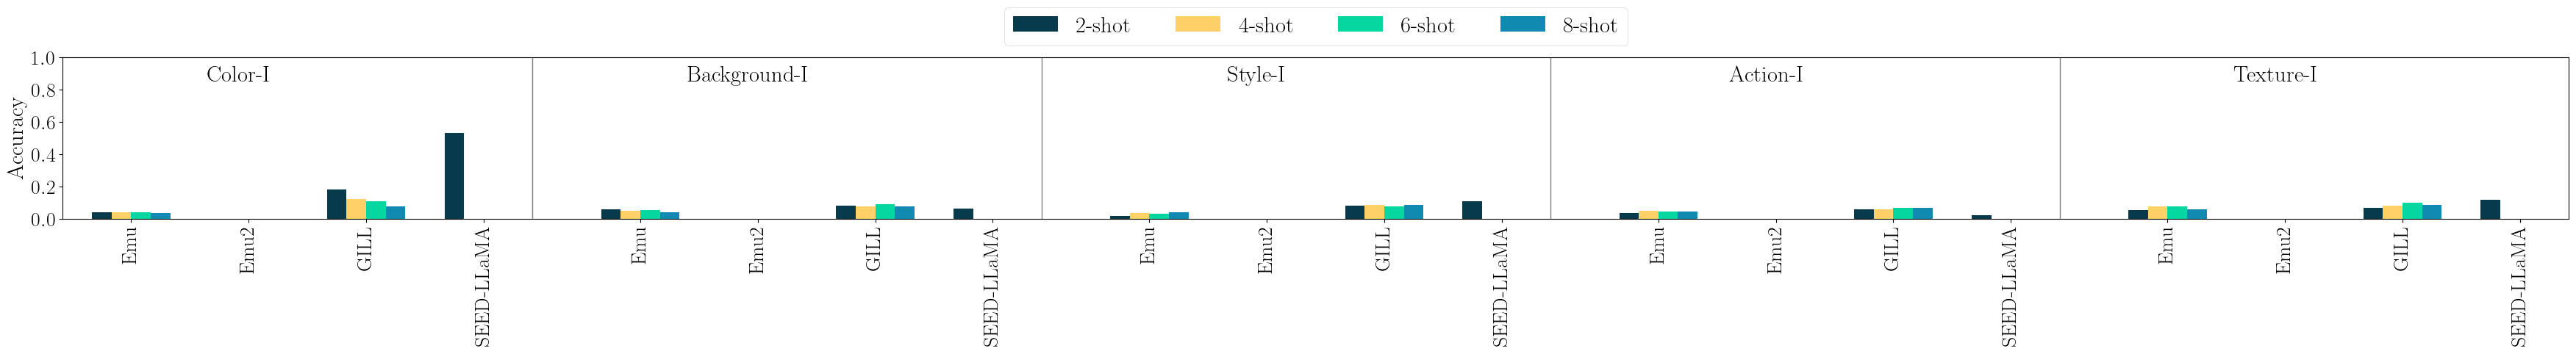

In [68]:
bar_width = 2.5
task_inference = 'object'
model_mode = 'image'
width, height = 35, 5
misleading = 1
metric = 'overall'
wspace = 5
barspace = 15

r1_data = get_shot_bars(
    num_shot = 2,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


r2_data = get_shot_bars(
    num_shot = 4,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

r3_data = get_shot_bars(
    num_shot = 6,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

r4_data = get_shot_bars(
    num_shot = 8,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticks, xticklabels = [], []
for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
    ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
    ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
    ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
    ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
    xticks.append((v2['position'] + v3['position'])/2)
    xticklabels.append(model_dict[model_mode][v3['model']])
    
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
        ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
        
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
        if not i // len(model_dict[model_mode]) == 4:
            ax.axvline(x=v3['position'] + wspace, color='grey', linestyle='-', linewidth=1)
    
    # add legend
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
        
ax.set_xticks(xticks)
ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
# break the line of the xticklabels
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_yticks(np.arange(0, 1.2, 0.2))
# set ylabel 
ax.set_ylabel('Accuracy', fontsize=22)
save_path = f'{root_dir}/figures/{task_inference}_inference_m_{misleading}_{model_mode}.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
fig.savefig(save_path)
plt.show()

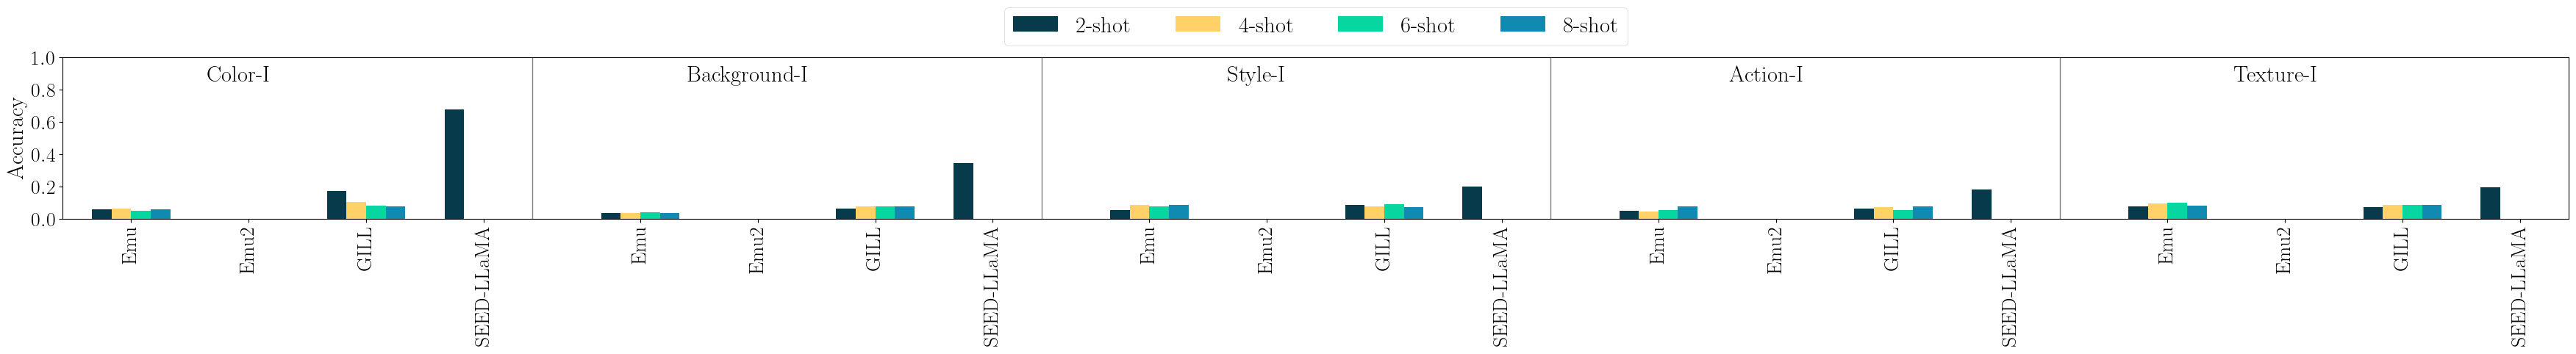

In [60]:
bar_width = 2.5
task_inference = 'object'
model_mode = 'image'
width, height = 35, 5
misleading = 0
metric = 'overall'
wspace = 5
barspace = 15

r1_data = get_shot_bars(
    num_shot = 2,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


r2_data = get_shot_bars(
    num_shot = 4,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

r3_data = get_shot_bars(
    num_shot = 6,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

r4_data = get_shot_bars(
    num_shot = 8,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    misleading = misleading,
)
r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticks, xticklabels = [], []
for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
    ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
    ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
    ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
    ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
    xticks.append((v2['position'] + v3['position'])/2)
    xticklabels.append(model_dict[model_mode][v3['model']])
    
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
        ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
        
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
        if not i // len(model_dict[model_mode]) == 4:
            ax.axvline(x=v3['position'] + wspace, color='grey', linestyle='-', linewidth=1)
    
    # add legend
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
        
ax.set_xticks(xticks)
ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
# break the line of the xticklabels
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_yticks(np.arange(0, 1.2, 0.2))
# set ylabel 
ax.set_ylabel('Accuracy', fontsize=22)
save_path = f'{root_dir}/figures/{task_inference}_inference_m_{misleading}_{model_mode}.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
fig.savefig(save_path)
plt.show()